In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [48]:
#Read a Dataset
DF = pd.read_csv('/content/New_CDF.csv',parse_dates=['Date/Time'], index_col='Date/Time')

In [49]:
#Handling Missing Days
def find_missing_days(df):
    df.index = pd.to_datetime(df.index)
    start_date = df.index.min()
    end_date = df.index.max()
    expected_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    actual_dates = pd.Series(df.index.date).unique()
    missing_days = expected_dates.difference(actual_dates)

    return missing_days

missing_days = find_missing_days(DF)

In [50]:
#k=0
#for missing_day in missing_days:
#    k+=1
#    print(k,missing_day)

In [51]:
#Cutting the data at the date where the sampling becomes uneven
end_date = pd.to_datetime('2019-01-06')
DF = DF.loc[DF.index <= end_date]
print("CDF",len(DF))

CDF 35281


In [52]:
############% Basic Cleaning
#No Null values
#No encoding
#No upsamplng/downsampling

#Drift Method:
null_count_before = DF['Peak Direction'].isnull().sum()
print(f'Number of null values in "Peak Direction" before drift correction: {null_count_before}')

def drp(df):
    df.index = pd.to_datetime(df.index)
    for col in df.columns:
        # phv finda placeholders (-99.90) and null values
        phv = (df[col] == -99.9) | df[col].isnull()

        # Iterates rows with placeholder/null values in the current column
        for i, row in df[phv].iterrows():
            start_time = i - pd.to_timedelta('1D')
            end_time = i + pd.to_timedelta('1D')
            fv = df[(df.index >= start_time) & (df.index <= end_time) & ~phv]

            if not fv.empty:
                mv = fv[col].mean()
                #Using df.at syntax to access a single point in the df
                df.at[i, col] = mv
    return df


df=drp(DF)
df.index = pd.to_datetime(df.index)

start_datetime = '2017-02-27 10:00'
end_datetime = '2017-02-28 01:00'

selected_columns = ['Peak Direction', 'SST']

# Calculate the average of the start and end datetime values for the selected columns
average_values = df.loc[[start_datetime, end_datetime], selected_columns].mean()

# Update the values
df.loc[(df.index > start_datetime) & (df.index < end_datetime), selected_columns] = average_values.values

#Created the final clean dataframe: df

Number of null values in "Peak Direction" before drift correction: 0


In [53]:
df.to_csv('/content/cleaned_1_df.csv', index=False)

Text(0.5, 1.0, 'Changes in Significant Wave Height over Time')

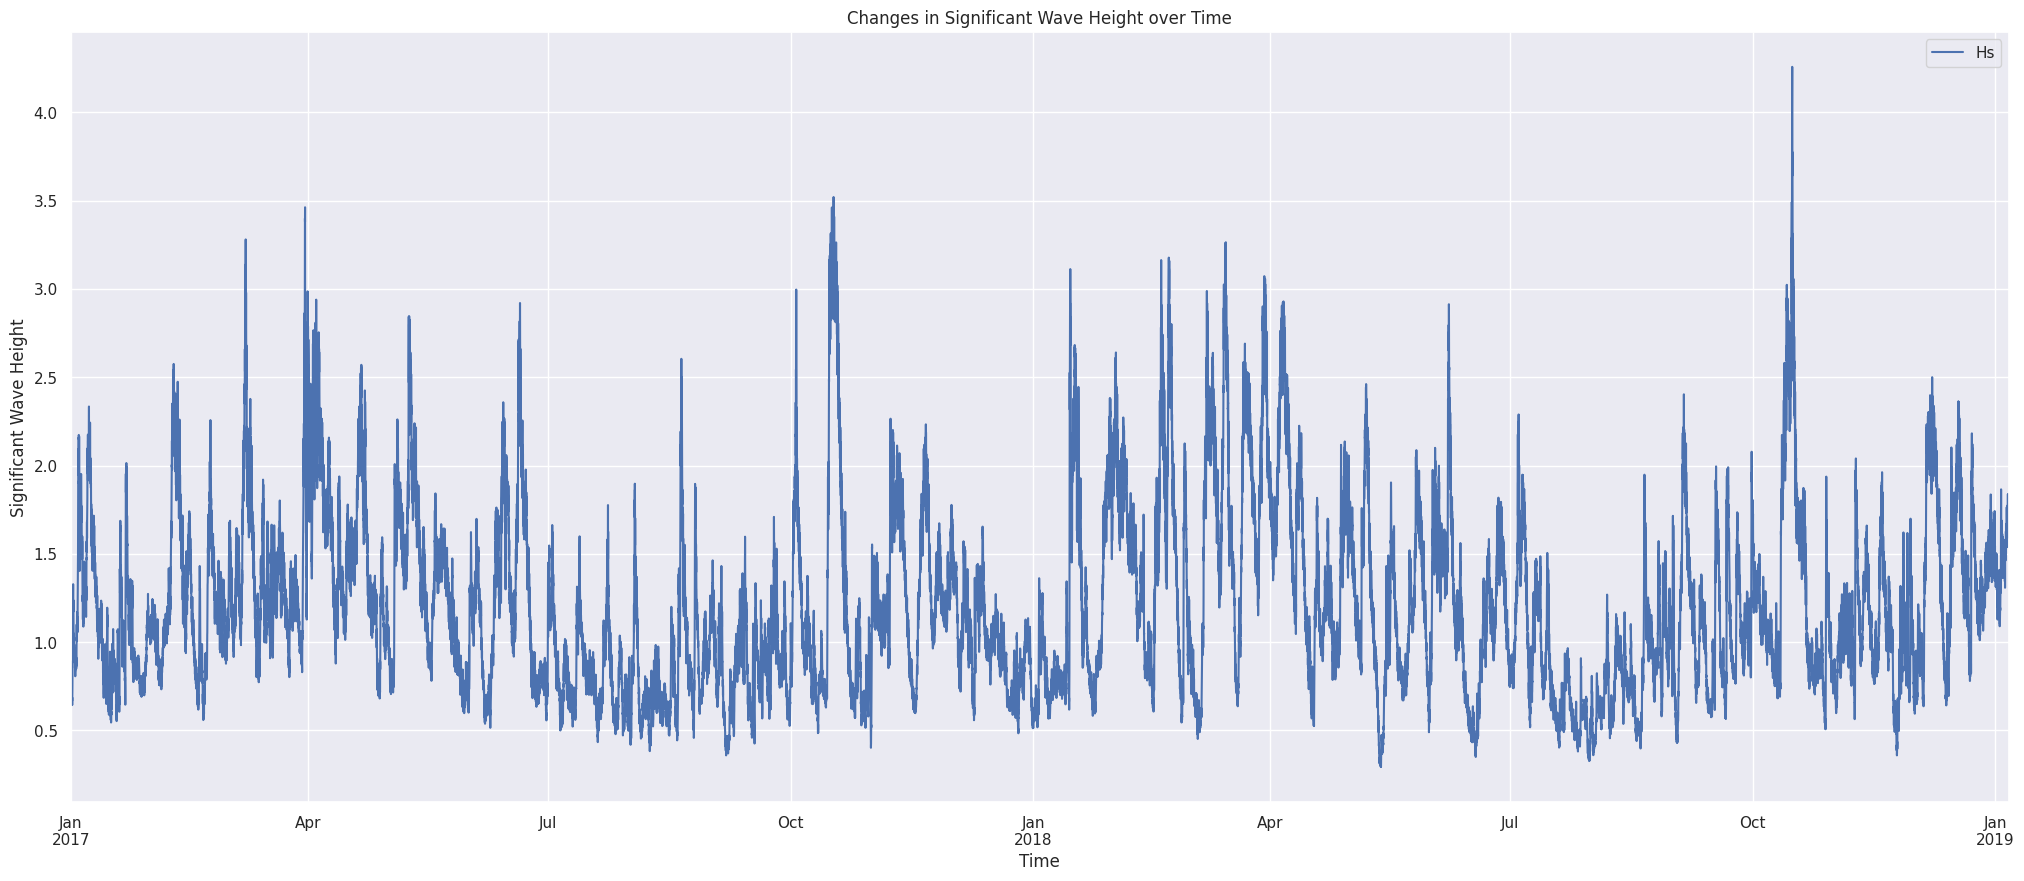

In [54]:
sns.set() # Seaborn-Stile verwenden
df[df.Hs > 0].pivot_table("Hs", index = df.index).plot(figsize=(25,10))
plt.ylabel("Significant Wave Height")
plt.xlabel("Time")
# displaying the title
plt.title("Changes in Significant Wave Height over Time")

Text(0.5, 1.0, 'Changes in Sea Surface Temperature over Time')

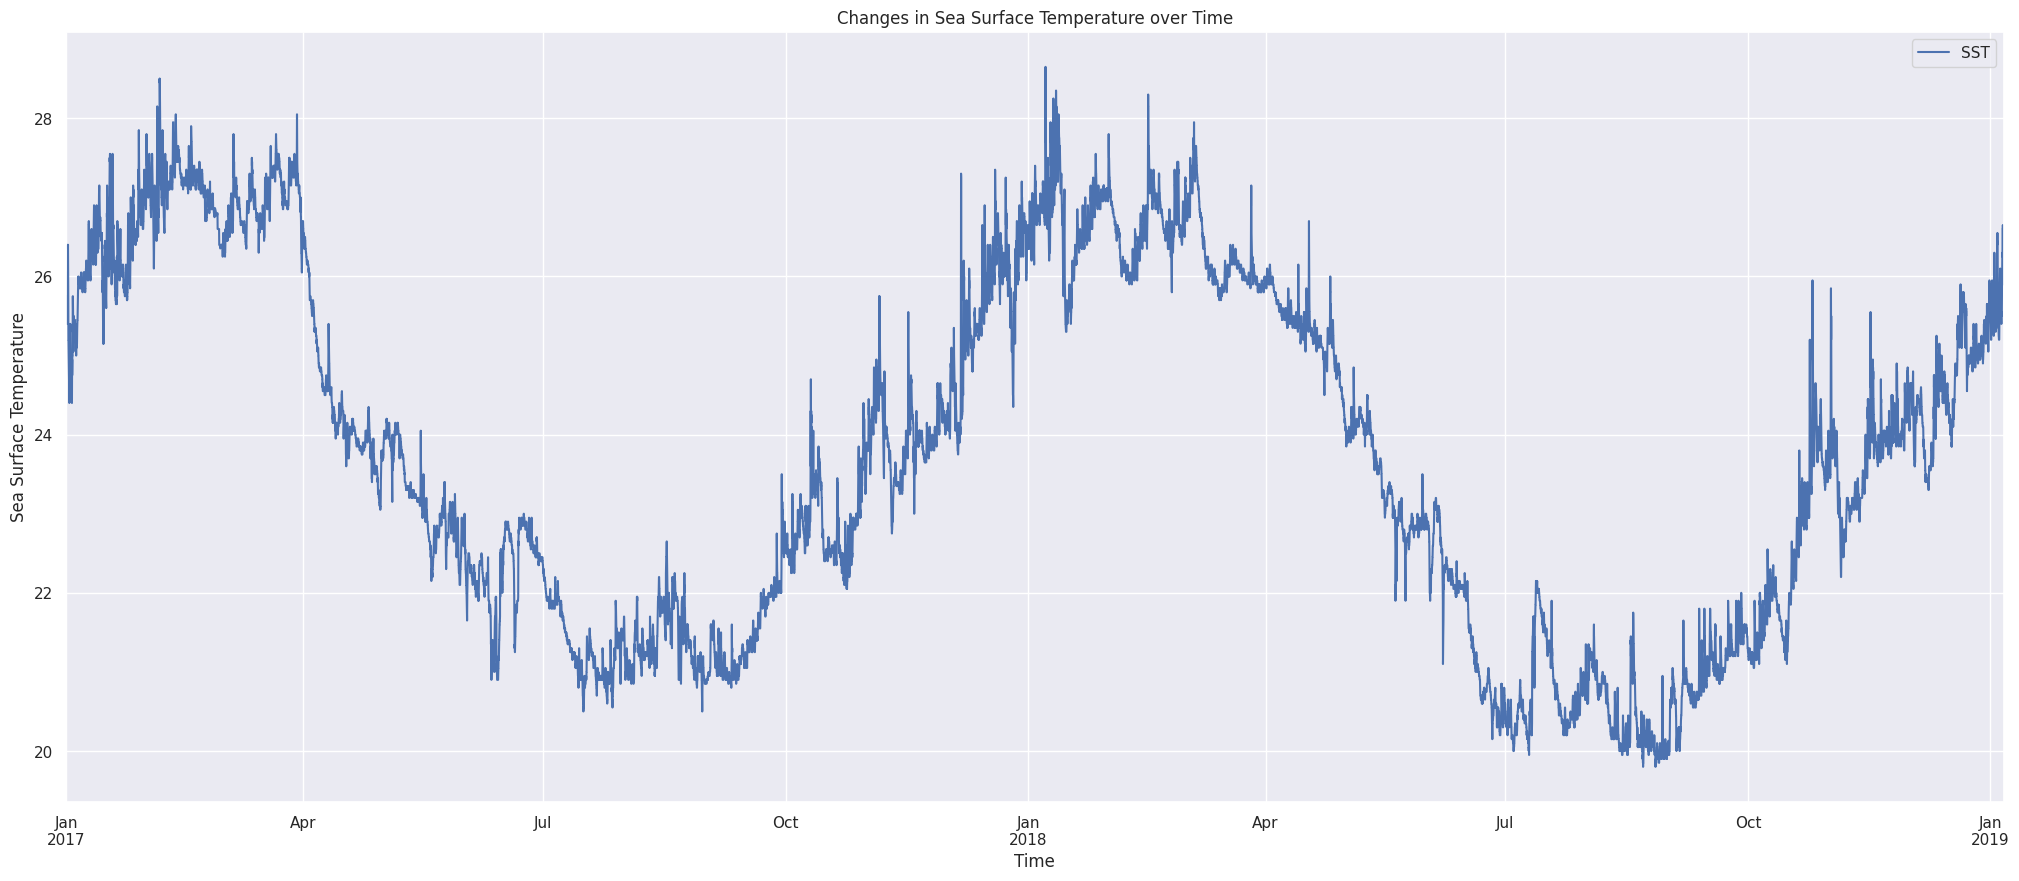

In [55]:
sns.set() # Seaborn-Stile verwenden
df[df.SST > 0].pivot_table("SST", index = df.index).plot(figsize=(25,10))
plt.ylabel("Sea Surface Temperature")
plt.xlabel("Time")
# displaying the title
plt.title("Changes in Sea Surface Temperature over Time")

Text(0.5, 1.0, 'Changes in Maximum Wave Height over Time')

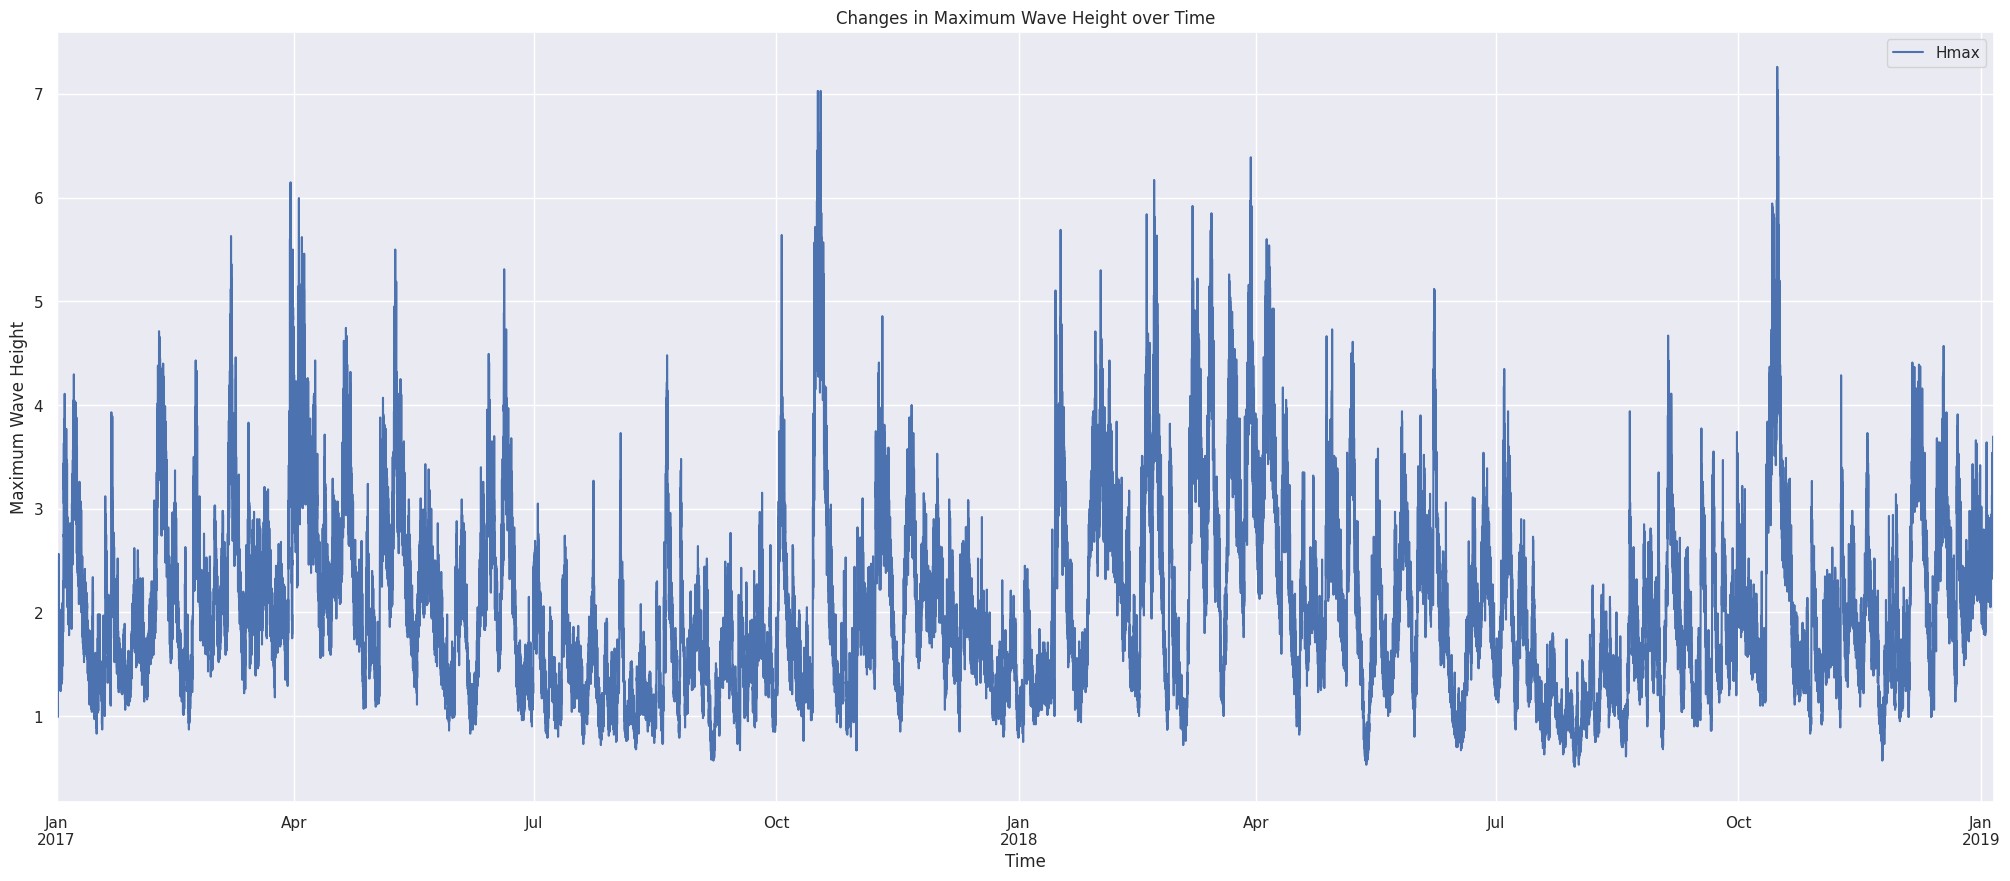

In [56]:
sns.set() # Seaborn-Stile verwenden
df[df.Hmax > 0].pivot_table("Hmax", index = df.index).plot(figsize=(25,10))
plt.ylabel("Maximum Wave Height")
plt.xlabel("Time")
# displaying the title
plt.title("Changes in Maximum Wave Height over Time")

In [57]:
df_1 = df.copy()

In [58]:
df_1['Date_Time'] = df_1.index

In [66]:
df_1['month'] = pd.to_datetime(df_1['Date_Time']).dt.month
df_1['year'] = pd.to_datetime(df_1['Date_Time']).dt.year
df_1_avg = df_1.groupby(['year','month'], as_index=False).mean()
#df_1_avg

<ipython-input-66-994fb16d96a1>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_1_avg = df_1.groupby(['year','month'], as_index=False).mean()


In [61]:
df_1_2017=df_1_avg[df_1_avg['year'] == 2017]
df_1_2017 = df_1_2017.reset_index()

In [62]:
df_1_2018=df_1_avg[df_1_avg['year'] == 2018]
df_1_2018 = df_1_2018.reset_index()

Text(0.5, 1.0, 'Comparing changes in Maximum Wave Height in 2017 / 2018')

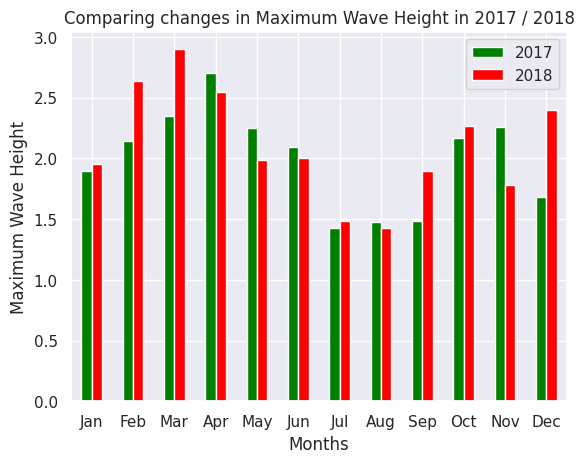

In [63]:
plot1_avg = pd.DataFrame({'2017': df_1_2017['Hmax'].tolist(), '2018': df_1_2018['Hmax'].tolist()}, index=index)
ax = plot1_avg.plot.bar(rot=0, color={"2017": "green", "2018": "red"})
plt.ylabel("Maximum Wave Height")
plt.xlabel("Months")
# displaying the title
plt.title("Comparing changes in Maximum Wave Height in 2017 / 2018")

Text(0.5, 1.0, 'Comparing changes in Sea Surface Temperature in 2017 / 2018')

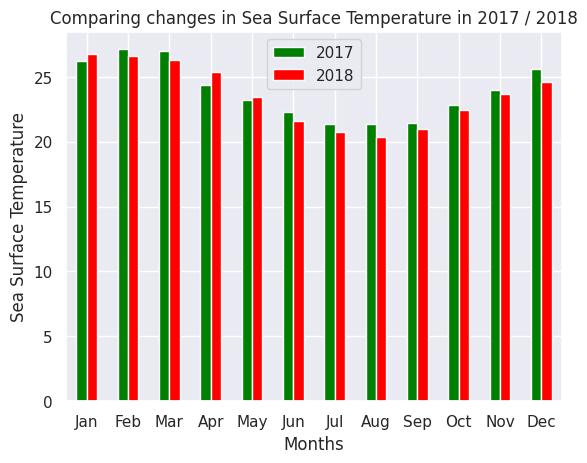

In [64]:
index = ['Jan', 'Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plot2_avg = pd.DataFrame({'2017': df_1_2017['SST'].tolist(), '2018': df_1_2018['SST'].tolist()}, index=index)
ax = plot2_avg.plot.bar(rot=0, color={"2017": "green", "2018": "red"})
plt.ylabel("Sea Surface Temperature")
plt.xlabel("Months")
# displaying the title
plt.title("Comparing changes in Sea Surface Temperature in 2017 / 2018")

Text(0.5, 1.0, 'Comparing changes in Significant Wave Height in 2017 / 2018')

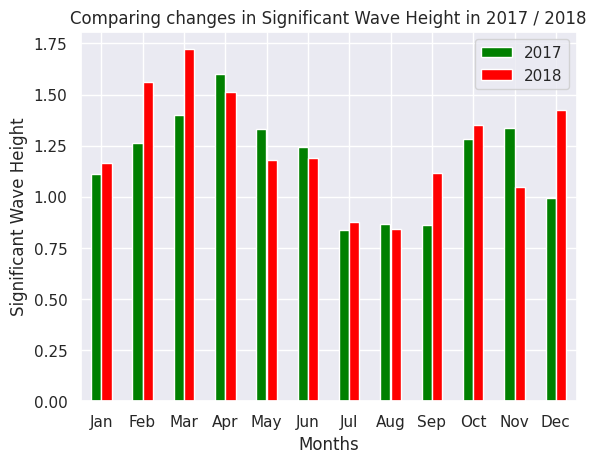

In [65]:
plot3_avg = pd.DataFrame({'2017': df_1_2017['Hs'].tolist(), '2018': df_1_2018['Hs'].tolist()}, index=index)
ax = plot3_avg.plot.bar(rot=0, color={"2017": "green", "2018": "red"})
plt.ylabel("Significant Wave Height")
plt.xlabel("Months")
# displaying the title
plt.title("Comparing changes in Significant Wave Height in 2017 / 2018")